# RLab06 - Gabriele Bertinelli (2103359)

In [ ]:
library(tidyverse)
library(gridExtra)
library(latex2exp)
library(emdbook)
library(bayestestR)
library(coda)
library(magrittr)
library(rstan)

set.seed(2103359)

In [2]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

#### 1)  
**1.1**

In [3]:
# sets of observations
n1 <- c(rep(0, times=109), rep(1, times = 65), rep(2, times=22), rep(3, times=3), rep(4, times=1))
n2 <- c(rep(0, times=144), rep(1, times = 91), rep(2, times=32), rep(3, times=11), rep(4, times=2))

delta.t <- 0.001
lambda_list <- seq(from=0, to=7, by=delta.t)

#likelihood for the two observation is poisson
poisson <- function(ni, lambda_list){
                pi_like <- 1 #rep(1, times = length(lambda_list))
                for (n in ni){
                    pi_like <- pi_like * dpois(x=n, lambda=lambda_list)
                }
                return(pi_like)
            }

#compute the two likelihood separatly for the two observation
p1_like <- poisson(n1,  lambda_list)
p2_like <- poisson(n2,  lambda_list)

In [4]:
# posterior with uniform prior
p.post_star_unif1 <- p1_like * 1
p.post_unif1 <- p.post_star_unif1 / (sum(p.post_star_unif1)*delta.t)

my.median = function(mu, post, dt=0.001){
    for (i in seq(1, length(mu))){
        int  = sum(post[1:i]*dt)
        if (int>0.4999){med=mu[i]
                    break
        }
    }
    return(med)
}

mean_unif1 <- sum(p.post_unif1 * lambda_list)*delta.t
median_unif1 <- my.median(lambda_list, p.post_unif1)
variance_unif1 <- sum(((mean_unif1-lambda_list)^2)*p.post_unif1)*delta.t

lower_unif1 <- ncredint(lambda_list, p.post_unif1, level = 0.95)[['lower']]
upper_unif1 <- ncredint(lambda_list, p.post_unif1, level = 0.95)[['upper']]


p.post_star_unif2 <- p2_like * 1 
p.post_unif2 <- p.post_star_unif2 / (sum(p.post_star_unif2)*delta.t)

mean_unif2 <- sum(p.post_unif2 * lambda_list)*delta.t
median_unif2 <- my.median(lambda_list, p.post_unif2)
variance_unif2 <- sum(((mean_unif2-lambda_list)^2)*p.post_unif2)*delta.t

lower_unif2 <- ncredint(lambda_list, p.post_unif2, level = 0.95)[['lower']]
upper_unif2 <- ncredint(lambda_list, p.post_unif2, level = 0.95)[['upper']]


result_unif <- data.frame(
                mean = c(mean_unif1, mean_unif2), 
                median = c(median_unif1, median_unif2),
                variance = c(variance_unif1, variance_unif2),
                l.ci = c(lower_unif1, lower_unif2),
                u.ci = c(upper_unif1, upper_unif2),
                row.names = c('1st set', '2nd set')
                )

In [5]:
print(sprintf('Mean value Set 1: %.3f  -  Mean value Set 2: %.3f', result_unif$mean[1], result_unif$mean[2]))

print(sprintf('Median value Set 1: %.3f  -  Median value Set 2: %.3f', result_unif$median[1], result_unif$median[2]))
cat('\n')

print(sprintf('SD Set 1: %.4f  -  SD Set 2: %.4f', result_unif$variance[1], result_unif$variance[2]))
cat('\n')

print(sprintf('0.95 CI Set 1 [%.3f - %.3f]', result_unif$l.ci[1], result_unif$u.ci[1]))

print(sprintf('0.95 CI Set 2 [%.3f - %.3f]', result_unif$l.ci[2], result_unif$u.ci[2]))

[1] "Mean value Set 1: 0.615  -  Mean value Set 2: 0.704"
[1] "Median value Set 1: 0.613  -  Median value Set 2: 0.702"

[1] "SD Set 1: 0.0031  -  SD Set 2: 0.0025"

[1] "0.95 CI Set 1 [0.508 - 0.724]"
[1] "0.95 CI Set 2 [0.607 - 0.802]"


Warning message:
"Removed 6250 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 6250 rows containing missing values or values outside the scale range (`geom_line()`)."


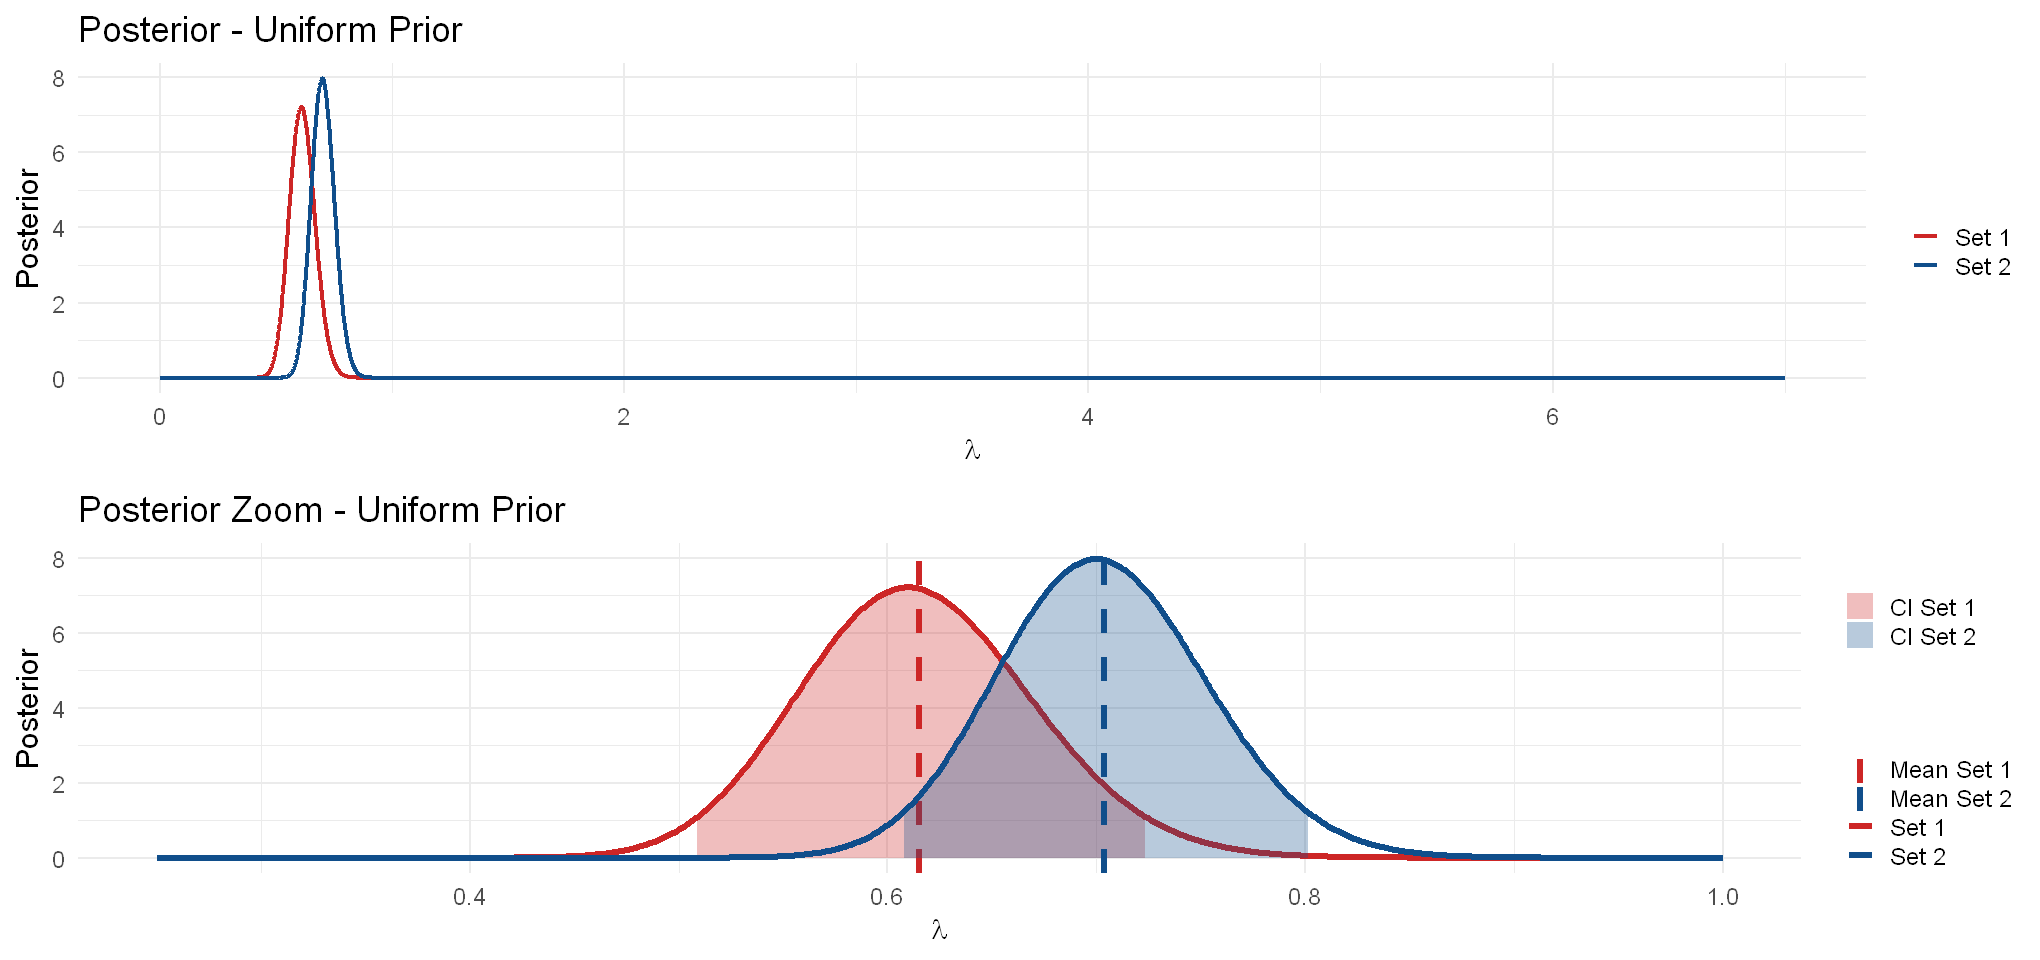

In [6]:
options(repr.plot.width = 17, repr.plot.height = 8)
# plot
unif.post.plot <- ggplot() +
        geom_line(aes(lambda_list, p.post_unif1, color='Set 1'), lwd=1.3) +
        geom_line(aes(lambda_list, p.post_unif2, color='Set 2'), lwd=1.3) +
        labs(x=(TeX(r'(\lambda)')), y ='Posterior', title='Posterior - Uniform Prior', color='') +
        theme_minimal(base_size=18) + 
        scale_color_manual(values = c('Set 1' = 'firebrick3', 'Set 2' = 'dodgerblue4'))

# zoom in plot
unif.post.plot.zoom <- ggplot() +
        geom_line(aes(lambda_list, p.post_unif1, color='Set 1'), lwd=1.7) + 
        geom_area(aes(x = lambda_list[lambda_list > lower_unif1 & lambda_list < upper_unif1], 
                      y = p.post_unif1[lambda_list > lower_unif1 & lambda_list < upper_unif1],
                      fill='CI Set 1'), alpha=0.3) +
        geom_vline(aes(xintercept=mean_unif1, color='Mean Set 1'), linetype='dashed', lwd=1.7) +

        geom_line(aes(lambda_list, p.post_unif2, color='Set 2'), lwd=1.7) + 
        geom_area(aes(x = lambda_list[lambda_list > lower_unif2 & lambda_list < upper_unif2], 
                      y = p.post_unif2[lambda_list > lower_unif2 & lambda_list < upper_unif2],
                      fill='CI Set 2'), alpha=0.3) +
        geom_vline(aes(xintercept=mean_unif2, color='Mean Set 2'), linetype='dashed', lwd=1.7) + 

        labs(x=(TeX(r'(\lambda)')), y ='Posterior', title='Posterior Zoom - Uniform Prior', color='', fill='') + 

        scale_color_manual(values = c('Set 1' = 'firebrick3', 'Mean Set 1' = 'firebrick3', 
                                      'Set 2' = 'dodgerblue4', 'Mean Set 2' = 'dodgerblue4')) +
        scale_fill_manual(values = c('CI Set 1' = 'firebrick3', 'CI Set 2' = 'dodgerblue4')) +
        theme_minimal(base_size = 18) +  

        ylim(0, 8) + xlim(0.25, 1)

grid.arrange(grobs=list(unif.post.plot, unif.post.plot.zoom), nrow=2, ncol=1)

**1.2)**

In [7]:
#posterior with Jeffrey prior
lambda_list <- seq(from=0.0001, to=10, by=delta.t)
p1_like <- poisson(n1,  lambda_list)
p2_like <- poisson(n2,  lambda_list)


p.post_star_Jeffrey1 <- p1_like * (1/sqrt(lambda_list))
p.post_Jeffrey1 <- p.post_star_Jeffrey1 / (sum(p.post_star_Jeffrey1)*delta.t)

mean_Jeffrey1 <- sum(p.post_Jeffrey1 * lambda_list)*delta.t
median_Jeffrey1 <- my.median(lambda_list, p.post_Jeffrey1)
variance_Jeffrey1 <- sum(((mean_Jeffrey1-lambda_list)^2)*p.post_Jeffrey1)*delta.t

lower_Jeffrey1 <- ncredint(lambda_list, p.post_Jeffrey1, level = 0.95)[['lower']]
upper_Jeffrey1 <- ncredint(lambda_list, p.post_Jeffrey1, level = 0.95)[['upper']]


p.post_star_Jeffrey2 <- p2_like * (1/sqrt(lambda_list)) 
p.post_Jeffrey2 <- p.post_star_Jeffrey2 / (sum(p.post_star_Jeffrey2)*delta.t)

mean_Jeffrey2 <- sum(p.post_Jeffrey2 * lambda_list)*delta.t
median_Jeffrey2 <- my.median(lambda_list, p.post_Jeffrey2)
variance_Jeffrey2 <- sum(((mean_Jeffrey2-lambda_list)^2)*p.post_Jeffrey2)*delta.t

lower_Jeffrey2 <- ncredint(lambda_list, p.post_Jeffrey2, level = 0.95)[['lower']]
upper_Jeffrey2 <- ncredint(lambda_list, p.post_Jeffrey2, level = 0.95)[['upper']]


result_jeff <- data.frame(
                mean = c(mean_Jeffrey1, mean_Jeffrey2), 
                median = c(median_Jeffrey1, median_Jeffrey2),
                variance = c(variance_Jeffrey1, variance_Jeffrey2),
                l.ci = c(lower_Jeffrey1, lower_Jeffrey2),
                u.ci = c(upper_Jeffrey1, upper_Jeffrey2),
                row.names = c('1st set', '2nd set')
                )

In [8]:
print(sprintf('Mean value Set 1: %.3f  -  Mean value Set 2: %.3f', result_jeff$mean[1], result_jeff$mean[2]))
print(sprintf('Median value Set 1: %.3f  -  Median value Set 2: %.3f', result_jeff$median[1], result_jeff$median[2]))
cat('\n')
print(sprintf('SD Set 1: %.4f  -  SD Set 2: %.4f', result_jeff$variance[1], result_jeff$variance[2]))
cat('\n')
print(sprintf('0.95 CI Set 1 [%.3f - %.3f]', result_jeff$l.ci[1], result_jeff$u.ci[1]))
print(sprintf('0.95 CI Set 2 [%.3f - %.3f]', result_jeff$l.ci[2], result_jeff$u.ci[2]))

[1] "Mean value Set 1: 0.612  -  Mean value Set 2: 0.702"
[1] "Median value Set 1: 0.611  -  Median value Set 2: 0.700"

[1] "SD Set 1: 0.0031  -  SD Set 2: 0.0025"

[1] "0.95 CI Set 1 [0.506 - 0.721]"
[1] "0.95 CI Set 2 [0.605 - 0.800]"


Warning message:
"Removed 9250 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 9250 rows containing missing values or values outside the scale range (`geom_line()`)."


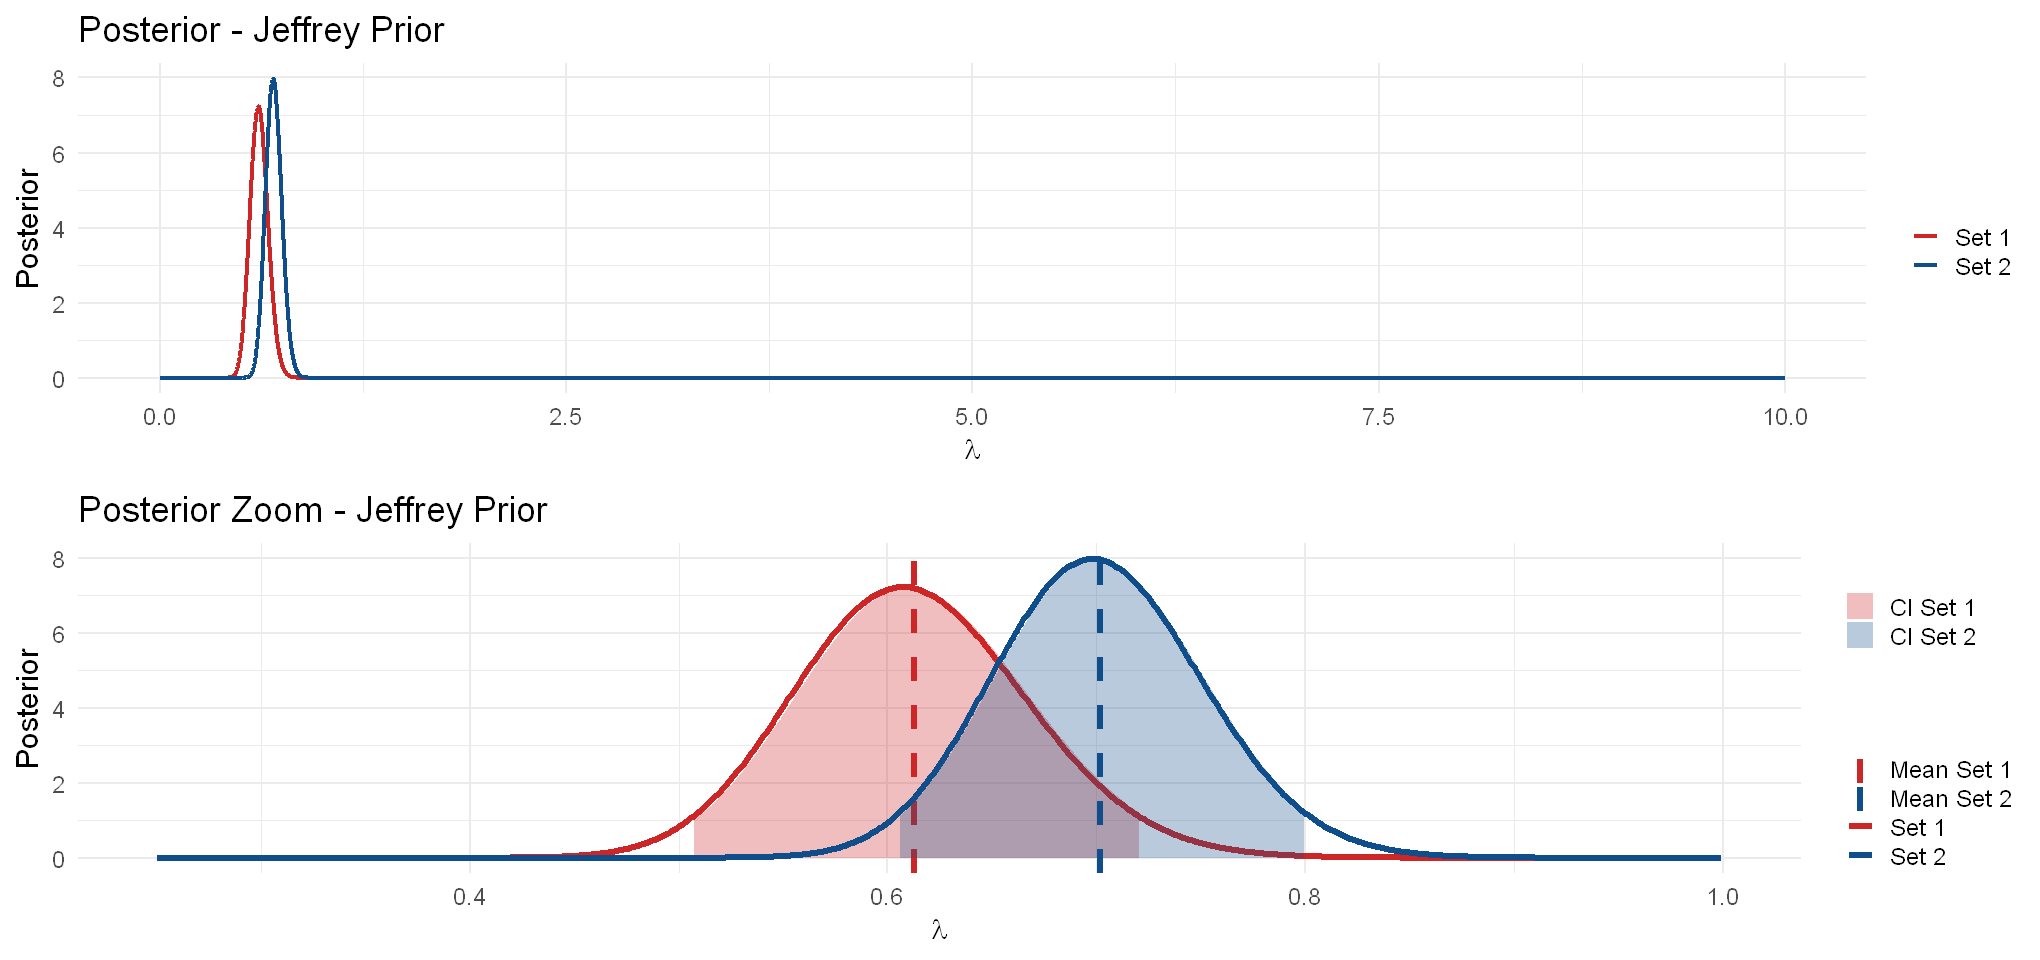

In [9]:
options(repr.plot.width = 17, repr.plot.height = 8)
# plot
jeff.post.plot <- ggplot() +
        geom_line(aes(lambda_list, p.post_Jeffrey1, color='Set 1'), lwd=1.3) +
        geom_line(aes(lambda_list, p.post_Jeffrey2, color='Set 2'), lwd=1.3) +
        labs(x=(TeX(r'(\lambda)')), y ='Posterior', title='Posterior - Jeffrey Prior', color='') +
        theme_minimal(base_size=18) + 
        scale_color_manual(values = c('Set 1' = 'firebrick3', 'Set 2' = 'dodgerblue4'))

# zoom in plot
jeff.post.plot.zoom <- ggplot() +
        geom_line(aes(lambda_list, p.post_Jeffrey1, color='Set 1'), lwd=1.7) + 
        geom_area(aes(x = lambda_list[lambda_list > lower_Jeffrey1 & lambda_list < upper_Jeffrey1], 
                      y = p.post_unif1[lambda_list > lower_Jeffrey1 & lambda_list < upper_Jeffrey1],
                      fill='CI Set 1'), alpha=0.3) +
        geom_vline(aes(xintercept=mean_Jeffrey1, color='Mean Set 1'), linetype='dashed', lwd=1.7) +

        geom_line(aes(lambda_list, p.post_Jeffrey2, color='Set 2'), lwd=1.7) + 
        geom_area(aes(x = lambda_list[lambda_list > lower_Jeffrey2 & lambda_list < upper_Jeffrey2], 
                      y = p.post_unif2[lambda_list > lower_Jeffrey2 & lambda_list < upper_Jeffrey2],
                      fill='CI Set 2'), alpha=0.3) +
        geom_vline(aes(xintercept=mean_Jeffrey2, color='Mean Set 2'), linetype='dashed', lwd=1.7) + 

        labs(x=(TeX(r'(\lambda)')), y ='Posterior', title='Posterior Zoom - Jeffrey Prior', color='', fill='') + 

        scale_color_manual(values = c('Set 1' = 'firebrick3', 'Mean Set 1' = 'firebrick3', 
                                      'Set 2' = 'dodgerblue4', 'Mean Set 2' = 'dodgerblue4')) +
        scale_fill_manual(values = c('CI Set 1' = 'firebrick3', 'CI Set 2' = 'dodgerblue4')) +
        theme_minimal(base_size = 18) +  

        ylim(0, 8) + xlim(0.25, 1)

grid.arrange(grobs=list(jeff.post.plot, jeff.post.plot.zoom), nrow=2, ncol=)

#### 2)  
**Uniform prior**

In [10]:
stan_unif <- stan_model(file = './model/sm_ex6.2_unif.stan')
y1 <- n1
N1 <- length(y1)

y2 <- n2
N2 <- length(y2)

dataList1 <- list(y = y1, N = N1)
dataList2 <- list(y = y2, N = N2)

In [11]:
stanFit1 <- sampling(object = stan_unif, data = dataList1, chains = 3, 
                     iter = 10000, warmup = 1000, thin = 1)

stanFit2 <- sampling(object = stan_unif, data = dataList2, chains = 3, 
                     iter = 10000, warmup = 1000, thin = 1)

In [12]:
print(sprintf('STAN fit with dataset 1'))
cat('\n')
print(stanFit1)

[1] "STAN fit with dataset 1"

Inference for Stan model: anon_model.
3 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=27000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
lambda    0.61    0.00 0.06    0.51    0.58    0.61    0.65    0.73  9871    1
lp__   -183.31    0.01 0.73 -185.39 -183.46 -183.03 -182.85 -182.79 11869    1

Samples were drawn using NUTS(diag_e) at Mon Jun  3 15:05:21 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [13]:
print(sprintf('STAN fit with dataset 2'))
cat('\n')
print(stanFit2)

[1] "STAN fit with dataset 2"

Inference for Stan model: anon_model.
3 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=27000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
lambda    0.70    0.00 0.05    0.61    0.67    0.70    0.74    0.81  8469    1
lp__   -266.76    0.01 0.70 -268.78 -266.91 -266.48 -266.31 -266.26 12499    1

Samples were drawn using NUTS(diag_e) at Mon Jun  3 15:05:31 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
chain1 <- rstan::As.mcmc.list(stanFit1, pars = c('lambda'))
summary(chain1)


Iterations = 1001:10000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 9000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6149246      0.0561459      0.0003417      0.0005661 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5106 0.5761 0.6131 0.6520 0.7299 


In [15]:
chain2 <- rstan::As.mcmc.list(stanFit2, pars = c('lambda'))
summary(chain2)


Iterations = 1001:10000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 9000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.7036984      0.0498203      0.0003032      0.0005383 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6097 0.6697 0.7023 0.7364 0.8052 


In [16]:
l.mean.1 <- summary(chain1)$statistics[1]
l.mean.2 <- summary(chain2)$statistics[1]

l.med.1 <- summary(chain1)$quantiles[3]
l.med.2 <- summary(chain2)$quantiles[3]

print(sprintf('Mean value Set 1: %.3f  -  Mean value Set 2: %.3f', l.mean.1, l.mean.2))
print(sprintf('Median value Set 1: %.3f  -  Median value Set 2: %.3f', l.med.1, l.med.2))
cat('\n')

l.lo.ci.1 <- summary(chain1)$quantiles[1]
l.up.ci.1 <- summary(chain1)$quantiles[5]
l.lo.ci.2 <- summary(chain2)$quantiles[1]
l.up.ci.2 <- summary(chain2)$quantiles[5]

print(sprintf('0.95 CI Set 1 [%.3f - %.3f]', l.lo.ci.1, l.up.ci.1))
print(sprintf('0.95 CI Set 2 [%.3f - %.3f]', l.lo.ci.2, l.up.ci.2))

[1] "Mean value Set 1: 0.615  -  Mean value Set 2: 0.704"
[1] "Median value Set 1: 0.613  -  Median value Set 2: 0.702"

[1] "0.95 CI Set 1 [0.511 - 0.730]"
[1] "0.95 CI Set 2 [0.610 - 0.805]"


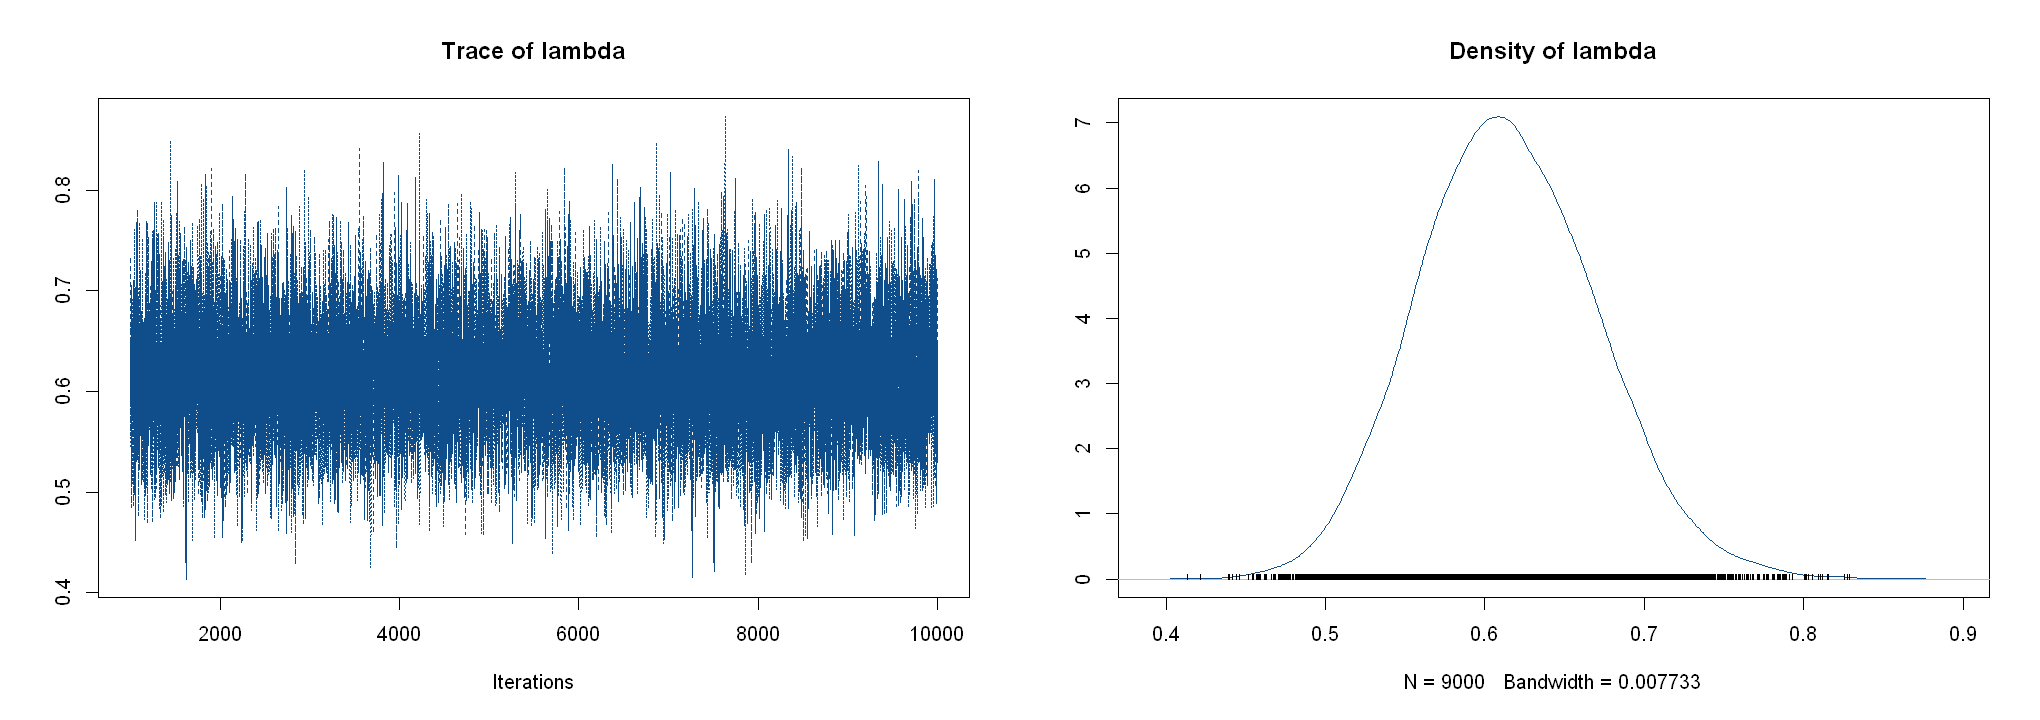

In [17]:
options(repr.plot.width = 17, repr.plot.height = 6)
plot(chain1, col='dodgerblue4')

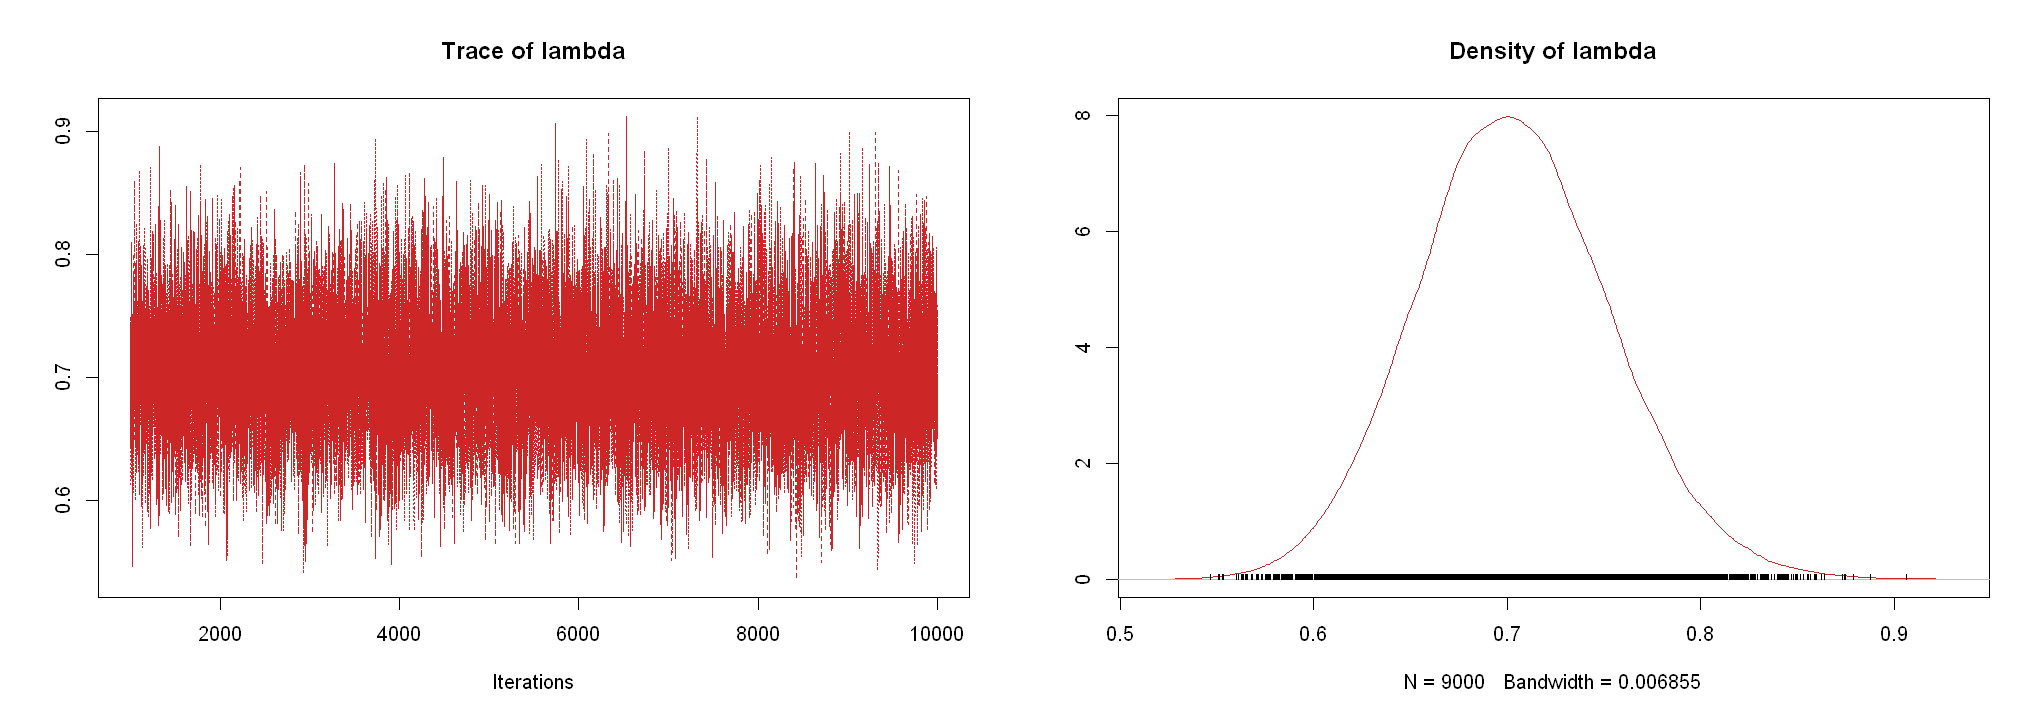

In [18]:
options(repr.plot.width = 17, repr.plot.height = 6)
plot(chain2, col='firebrick3')

**Jeffrey's prior**

In [19]:
stan_jeff <- stan_model(file = './model/sm_ex6.2_jeffrey.stan')
y1 <- n1
N1 <- length(y1)

y2 <- n2
N2 <- length(y2)

dataList1 <- list(y = y1, N = N1)
dataList2 <- list(y = y2, N = N2)

In [20]:
stanJeff1 <- sampling(object = stan_jeff, data = dataList1, chains = 3, 
                     iter = 10000, warmup = 1000, thin = 1)

stanJeff2 <- sampling(object = stan_jeff, data = dataList2, chains = 3, 
                     iter = 10000, warmup = 1000, thin = 1)

In [21]:
print(sprintf('STAN fit with dataset 1'))
cat('\n')
print(stanJeff1)

[1] "STAN fit with dataset 1"

Inference for Stan model: anon_model.
3 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=27000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
lambda    0.61    0.00 0.06    0.51    0.57    0.61    0.65    0.72  9202    1
lp__   -182.81    0.01 0.72 -184.85 -182.98 -182.53 -182.36 -182.30  9982    1

Samples were drawn using NUTS(diag_e) at Mon Jun  3 15:05:46 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
print(sprintf('STAN fit with dataset 2'))
cat('\n')
print(stanJeff2)

[1] "STAN fit with dataset 2"

Inference for Stan model: anon_model.
3 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=27000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
lambda    0.70    0.00 0.05    0.60    0.67    0.70    0.73    0.80  9470    1
lp__   -266.42    0.01 0.74 -268.55 -266.56 -266.14 -265.96 -265.91 10720    1

Samples were drawn using NUTS(diag_e) at Mon Jun  3 15:05:56 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [23]:
chain1 <- rstan::As.mcmc.list(stanJeff1, pars = c('lambda'))
summary(chain1)


Iterations = 1001:10000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 9000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6097067      0.0555149      0.0003379      0.0005698 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5060 0.5717 0.6078 0.6463 0.7230 


In [24]:
chain2 <- rstan::As.mcmc.list(stanJeff2, pars = c('lambda'))
summary(chain2)


Iterations = 1001:10000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 9000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.6998283      0.0504295      0.0003069      0.0005061 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6041 0.6654 0.6987 0.7330 0.8022 


In [25]:
l.mean.1 <- summary(chain1)$statistics[1]
l.mean.2 <- summary(chain2)$statistics[1]

l.med.1 <- summary(chain1)$quantiles[3]
l.med.2 <- summary(chain2)$quantiles[3]

print(sprintf('Mean value Set 1: %.3f  -  Mean value Set 2: %.3f', l.mean.1, l.mean.2))
print(sprintf('Median value Set 1: %.3f  -  Median value Set 2: %.3f', l.med.1, l.med.2))
cat('\n')

l.lo.ci.1 <- summary(chain1)$quantiles[1]
l.up.ci.1 <- summary(chain1)$quantiles[5]
l.lo.ci.2 <- summary(chain2)$quantiles[1]
l.up.ci.2 <- summary(chain2)$quantiles[5]

print(sprintf('0.95 CI Set 1 [%.3f - %.3f]', l.lo.ci.1, l.up.ci.1))
print(sprintf('0.95 CI Set 2 [%.3f - %.3f]', l.lo.ci.2, l.up.ci.2))

[1] "Mean value Set 1: 0.610  -  Mean value Set 2: 0.700"
[1] "Median value Set 1: 0.608  -  Median value Set 2: 0.699"

[1] "0.95 CI Set 1 [0.506 - 0.723]"
[1] "0.95 CI Set 2 [0.604 - 0.802]"


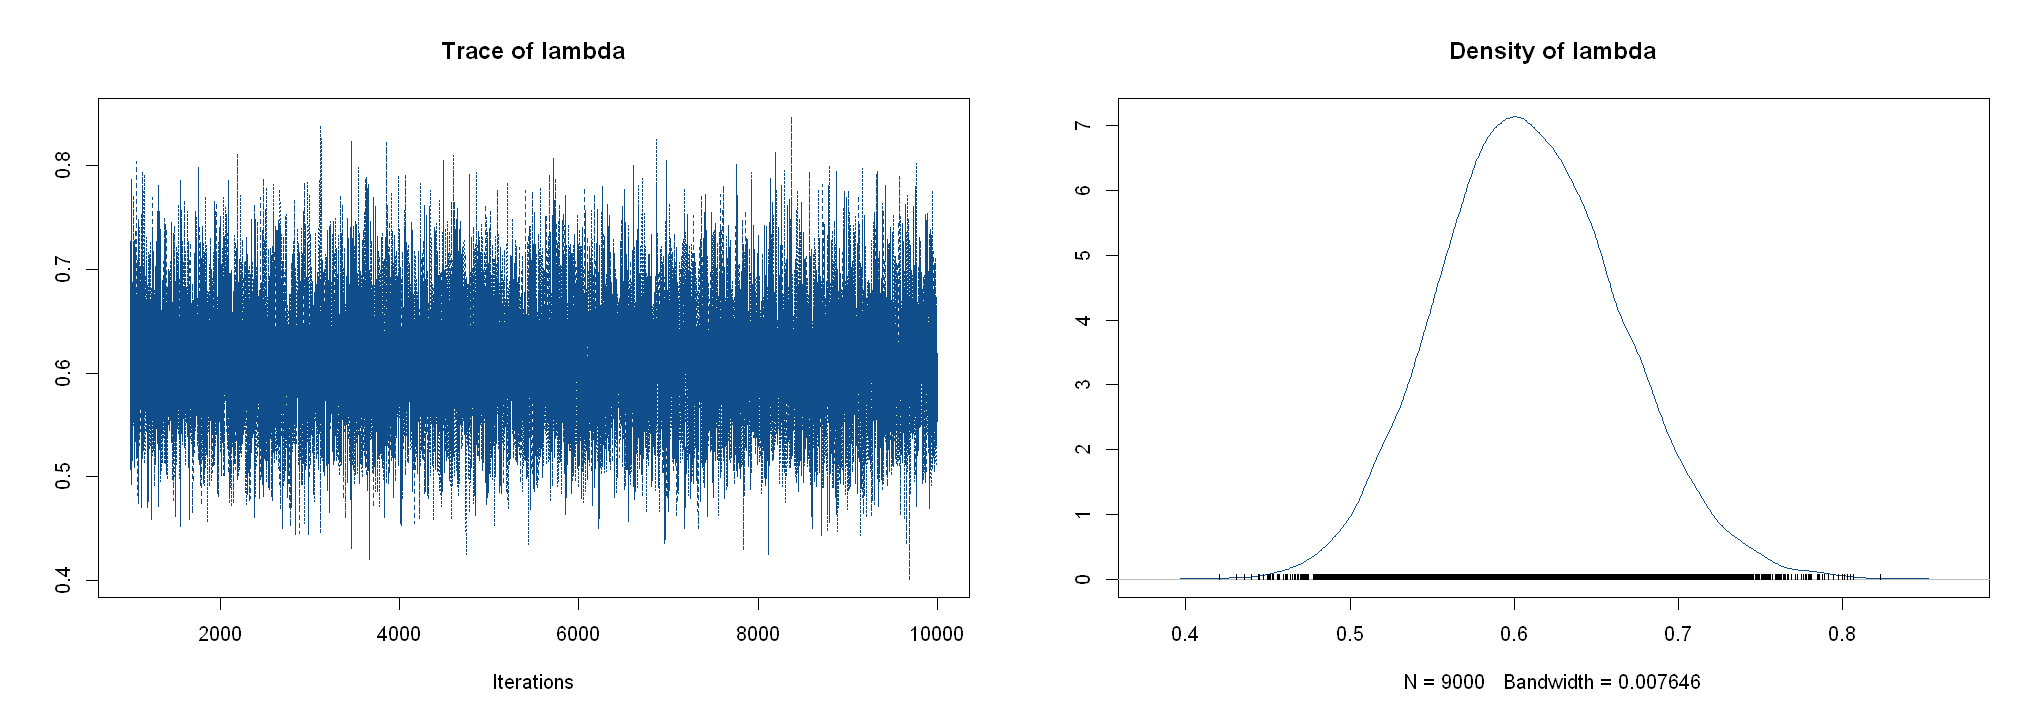

In [26]:
options(repr.plot.width = 17, repr.plot.height = 6)
plot(chain1, col='dodgerblue4')

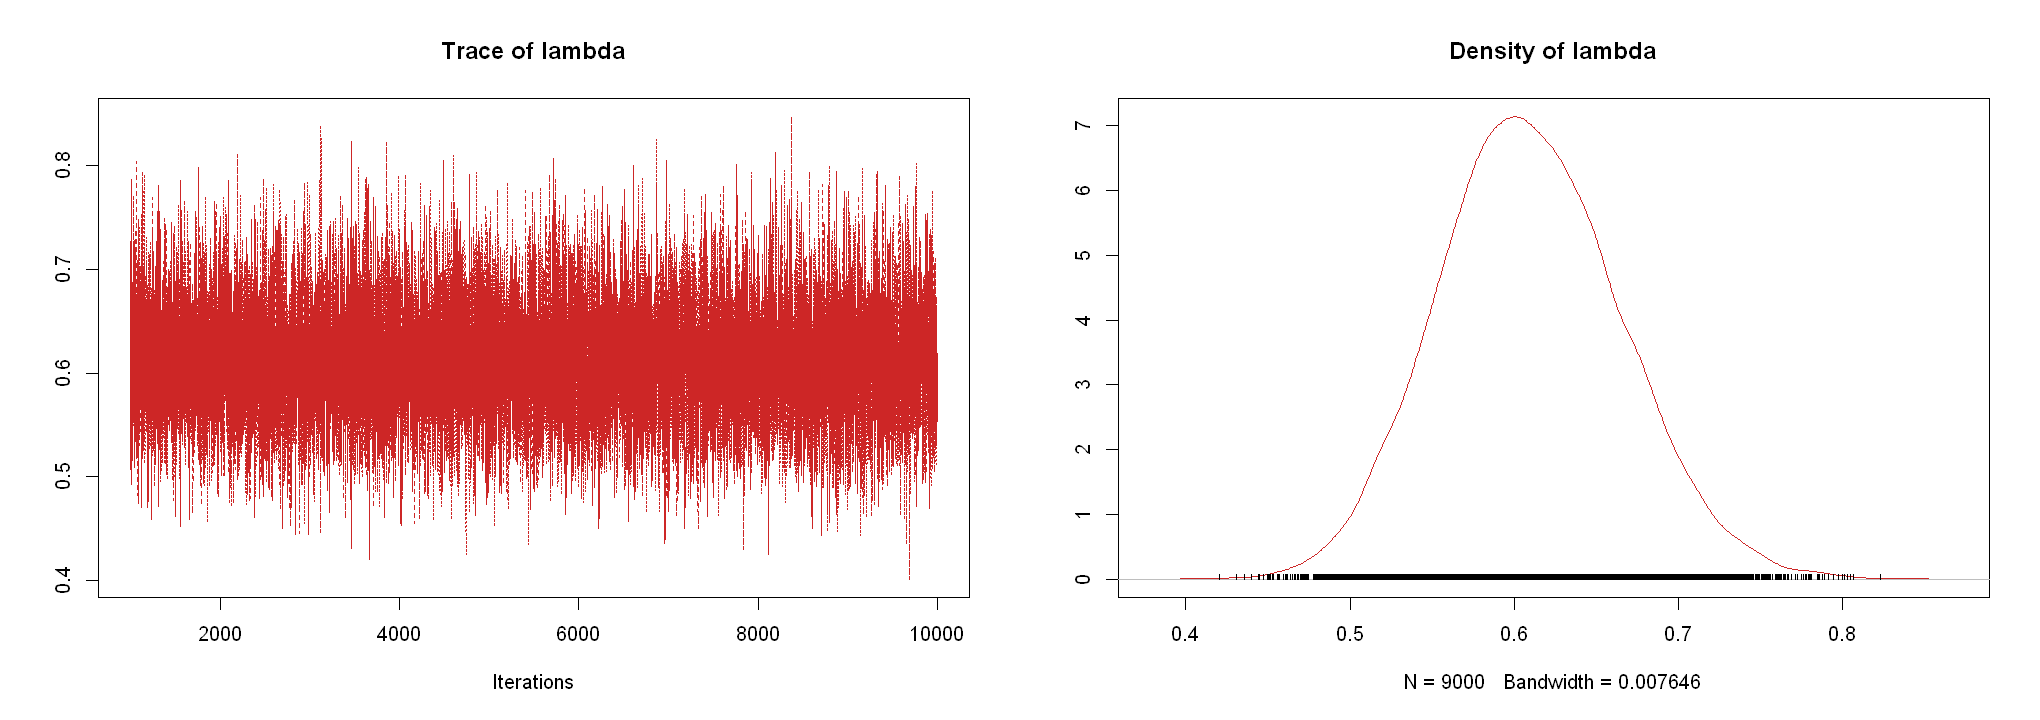

In [27]:
options(repr.plot.width = 17, repr.plot.height = 6)
plot(chain1, col='firebrick3')

#### 3)

In [28]:
n <- 116 #n° of sample
y <- 11 #samples w/ hl bacteria 

**3.1)**

In [29]:
p_freq <-  y/n

cat('The frequenties estimator is:', round(p_freq*100, 2), '%')

The frequenties estimator is: 9.48 %

**3.2)**

In [30]:
delta.t <- 0.0001
p <- seq(0, 1, by = delta.t) 

#Likelihood, Prior
p.beta_like <- dbinom(y, size=n, prob=p)
p.beta_prior <- dbeta(p, 1, 10)

#Posterior normalized
p.beta_post <- (p.beta_like * p.beta_prior)/(delta.t * sum(p.beta_like * p.beta_prior))

options(repr.plot.width=8, repr.plot.height=7)
#Plot
beta_post_plot <- ggplot() +
        geom_line(aes(x=p, y=p.beta_post), color='dodgerblue4', lwd=1.7) +
        labs(x='p', y='Posterior', title='Posterior from Beta prior') + 
        theme_minimal(base_size = 18)
# beta_post_plot

**3.3)**

mean,variance,l.ci,u.ci
<dbl>,<dbl>,<dbl>,<dbl>
0.09448819,0.0006684388,0.0467,0.1459


Warning message:
"Removed 8000 rows containing missing values or values outside the scale range (`geom_line()`)."


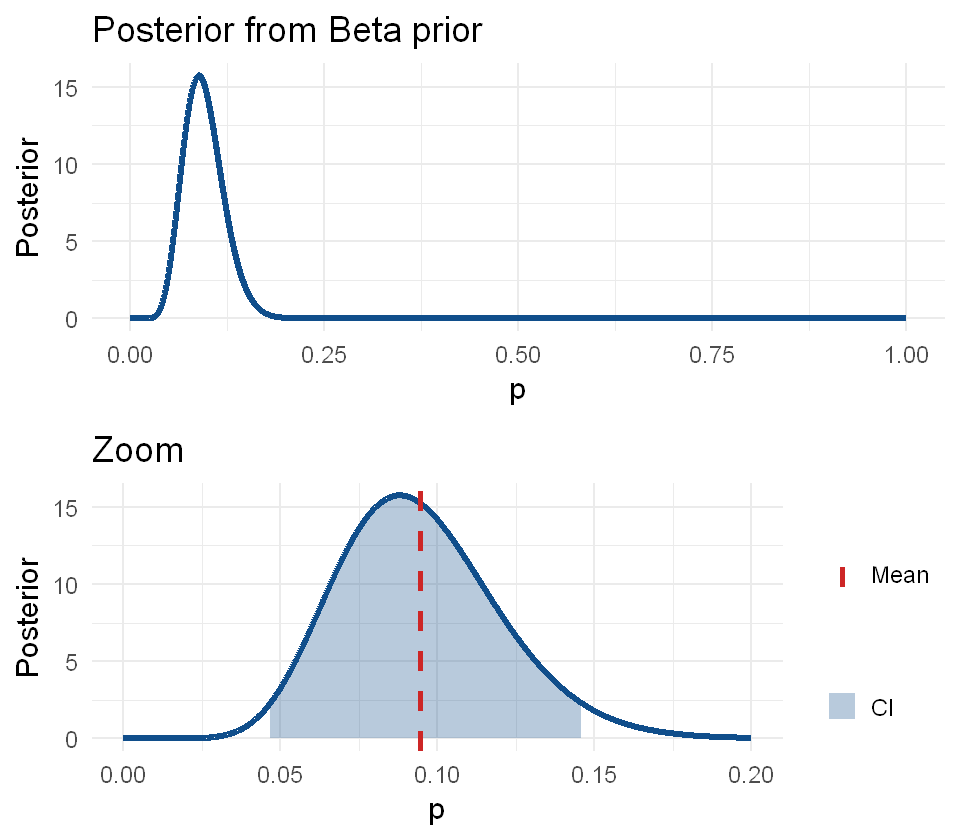

In [31]:
# Bayesian estimator for p 
beta_mean <- (sum(p.beta_post * p)) * delta.t
beta_var <- sum(((beta_mean - p)^2) *p.beta_post) * delta.t

beta_low <- ncredint(p, p.beta_post, level=0.95)[['lower']]
beta_up <- ncredint(p, p.beta_post, level=0.95)[['upper']]

beta_res <- tibble(
                mean = beta_mean,
                variance = beta_var,
                l.ci = beta_low,
                u.ci = beta_up
                )
beta_res

# zoomed plot
beta.plot.bayes <- beta_post_plot + 
        geom_area(aes(x = p[p>beta_low & p<beta_up],
                      y = p.beta_post[p>beta_low & p<beta_up],   
                      fill='CI'), alpha=0.3) +
        geom_vline(aes(xintercept = beta_mean, color='Mean'), linetype="dashed", linewidth=1.5) +
        scale_color_manual(values = c('Mean' = 'firebrick3')) + 
        scale_fill_manual(values = c('CI' = 'dodgerblue4')) +
        xlim(0, 0.2) +
        labs(title='Zoom', color='', fill='')

grid.arrange(grobs=list(beta_post_plot, beta.plot.bayes), nrow=2)

**3.4)**  

**Frequentist approach**

In [32]:
#Frequentist Approach
alpha = 0.05
p = seq(0, n, 1)
p.freq = pbinom(p, n, prob=0.1, lower.tail = TRUE)

lower.limit = max(p[p.freq<=alpha/2])
upper.limit = min(p[p.freq>=1-alpha/2])

alpha.star = p.freq[lower.limit] + 1 - p.freq[upper.limit]
cat('The closest we can get to alpha=0.05 is: ', alpha.star, '\n')
cat('The lower and upper limit to the 95% interval are: (', lower.limit, ', ', upper.limit, ')\n')
cat('Since the number of successful events (',y,') fall whithin this range, we CANNOT reject the null hypotesis. ')

The closest we can get to alpha=0.05 is:  0.04761008 
The lower and upper limit to the 95% interval are: ( 5 ,  18 )
Since the number of successful events ( 11 ) fall whithin this range, we CANNOT reject the null hypotesis. 

Warning message:
"Removed 88 rows containing missing values or values outside the scale range (`geom_col()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_col()`)."
Warning message:
"Removed 87 rows containing missing values or values outside the scale range (`geom_col()`)."


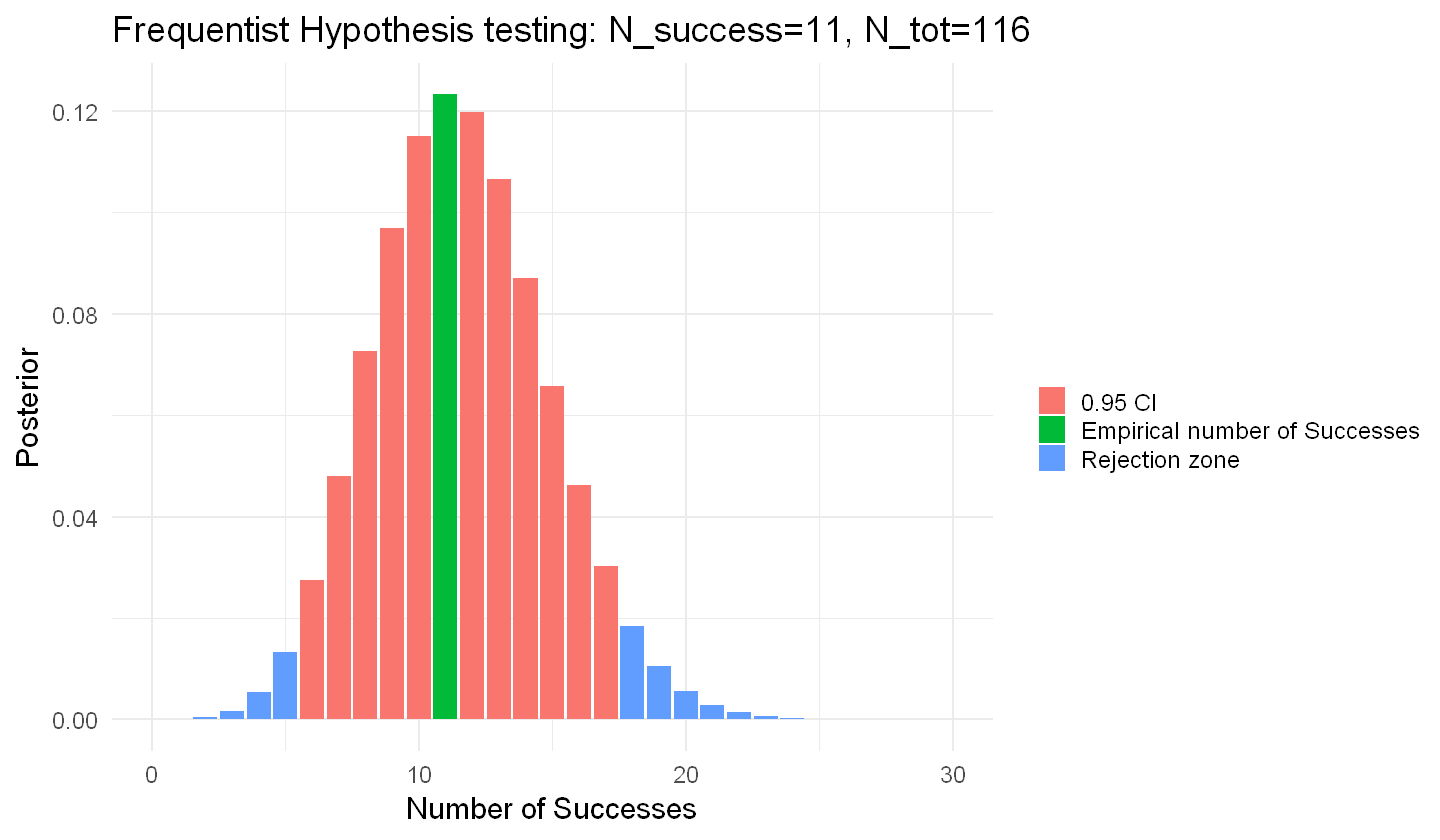

In [33]:
options(repr.plot.width=12, repr.plot.height=7)
h0.freq <- ggplot()+
    geom_col(aes(x=p, y=dbinom(p, n, 0.1), fill='0.95 CI'))+
    geom_col(aes(x=p[p.freq<=alpha/2], y=dbinom(p[p.freq<=alpha/2], n, 0.1), fill='Rejection zone'))+
    geom_col(aes(x=p[p.freq>=1-alpha/2], y=dbinom(p[p.freq>=1-alpha/2], n, 0.1), fill='Rejection zone'))+
    geom_col(aes(x=y, y=dbinom(y, n, 0.1), fill='Empirical number of Successes'))+
    xlim(0, 30)+
    labs(x='Number of Successes', y = 'Posterior', title='Frequentist Hypothesis testing: N_success=11, N_tot=116', fill='') +
    theme_minimal(base_size = 18)
h0.freq

**Bayesian approach**

In [34]:
cat('Since p=0.1 fall whithin the 95% CI (',beta_low,',',beta_up,') we CANNOT reject the null hypothesis.')

Since p=0.1 fall whithin the 95% CI ( 0.0467 , 0.1459 ) we CANNOT reject the null hypothesis.

**3.5**

In [35]:
n <- 165
y <- 9

p_freq <- y/n
cat('The frequenties estimator is:', round(p_freq*100, 2), '%')

The frequenties estimator is: 5.45 %

**3.6 - 3.7)**

,Mean,Variance,l.ci,u.ci
,<dbl>,<dbl>,<dbl>,<dbl>
Prior: Beta,0.05681818,0.0003027677,0.0251,0.0914
Prior: Old posterior,0.07191781,0.0002278008,0.0436,0.0251


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
"Removed 7500 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 7500 rows containing missing values or values outside the scale range (`geom_line()`)."


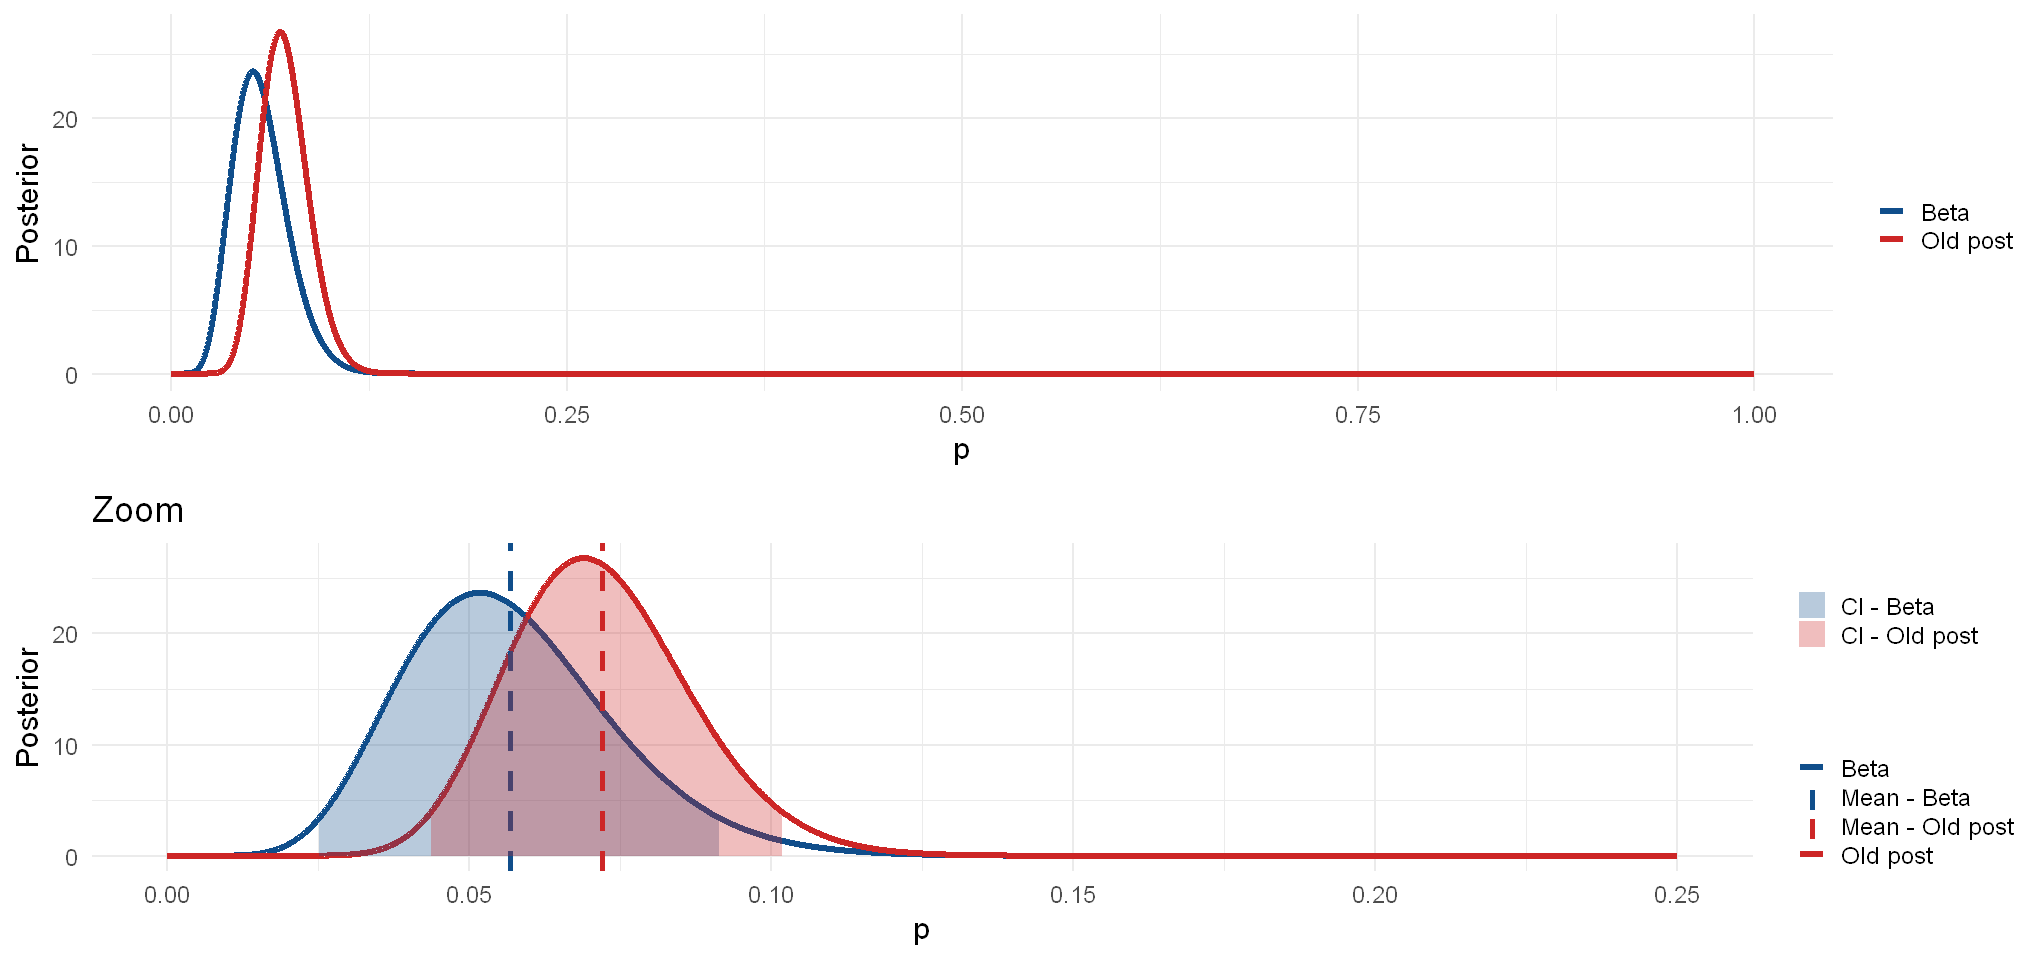

In [36]:
delta.t <- 0.0001
p <- seq(0, 1, by=delta.t)

#likelihood
p.like <- dbinom(y, n, prob=p)

#the two prior
p.beta_prior <- dbeta(p, 1, 10)
p.old_prior <- p.beta_post

#the two possible posterior 
p.beta_post <- (p.like * p.beta_prior) / (delta.t * sum(p.like * p.beta_prior))

p.old_post <- (p.like * p.old_prior) / (delta.t * sum(p.like * p.old_prior))

#find the two baiesian estimator for the two posterior 
beta_mean <- sum(p * p.beta_post) * delta.t
beta_var <- sum(((p-beta_mean)^2) * p.beta_post) * delta.t
beta_low <- ncredint(p, p.beta_post, level = 0.95)[['lower']]
beta_up <- ncredint(p, p.beta_post, level = 0.95)[['upper']]
beta_cred_int <- c(beta_low, beta_up)


old_mean <- sum(p * p.old_post) * delta.t
old_var <- sum(((p-old_mean)^2) * p.old_post) * delta.t
old_low <- ncredint(p, p.old_post, level=0.95)[['lower']]
old_up <- ncredint(p, p.old_post, level=0.95)[['upper']]
old_cred_int <- c(old_low, old_up) 

#print the result in a dataframe
result <- data.frame(
          Mean = c(beta_mean, old_mean),
          Variance = c(beta_var, old_var),
          l.ci = c(beta_low, old_low),
          u.ci = c(beta_up, beta_low),
          row.names = c('Prior: Beta', 'Prior: Old posterior')
)
result

options(repr.plot.width = 17, repr.plot.height = 8)
#plot the two posterior 
prior_plot <- ggplot()+
        geom_line(aes(p, p.beta_post, color='Beta'), lwd=1.7) +
        geom_line(aes(p, p.old_post, color='Old post'), lwd=1.7) +
        scale_color_manual(values = c('Beta' = 'dodgerblue4', 'Old post' = 'firebrick3')) +
        theme_minimal(base_size = 18) +
        labs(x='p', y='Posterior', color='')

prior_plot_zoom <- prior_plot +
        geom_vline(aes(xintercept=beta_mean, color = 'Mean - Beta'), linetype='dashed', lwd=1.5) + 
        geom_area(aes(x = p[p>beta_low & p<beta_up],
                      y = p.beta_post[p>beta_low & p<beta_up],   
                      fill='CI - Beta'), alpha=0.3) +

        geom_vline(aes(xintercept=old_mean, color='Mean - Old post'), linetype='dashed', lwd=1.5) +
        geom_area(aes(x = p[p>old_low & p<old_up],
                      y = p.old_post[p>old_low & p<old_up],   
                      fill='CI - Old post'), alpha=0.3) +
        scale_color_manual(values = c('Beta' = 'dodgerblue4', 'Old post' = 'firebrick3', 
                                      'Mean - Beta' = 'dodgerblue4', 'Mean - Old post' = 'firebrick3')) +
        scale_fill_manual(values = c('CI - Beta' = 'dodgerblue4', 'CI - Old post' = 'firebrick3')) +
        theme_minimal(base_size = 18) +   
        xlim(0, 0.25) + 
        labs(title='Zoom', color='', fill='')

grid.arrange(grobs=list(prior_plot, prior_plot_zoom), nrow=2, ncol=1)

**3.8)**  

**Frequentist approach**

The closest we can get to alpha=0.05 is:  0.04532508 
The lower and upper limit to the 95% interval are: ( 8 ,  24 )
Since the number of successful events ( 9 ) slightly fall whithin this range, we are not sure if we CAN or
    CANNOT reject the null hypotesis. 


Warning message:
"Removed 137 rows containing missing values or values outside the scale range (`geom_col()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_col()`)."
Warning message:
"Removed 136 rows containing missing values or values outside the scale range (`geom_col()`)."


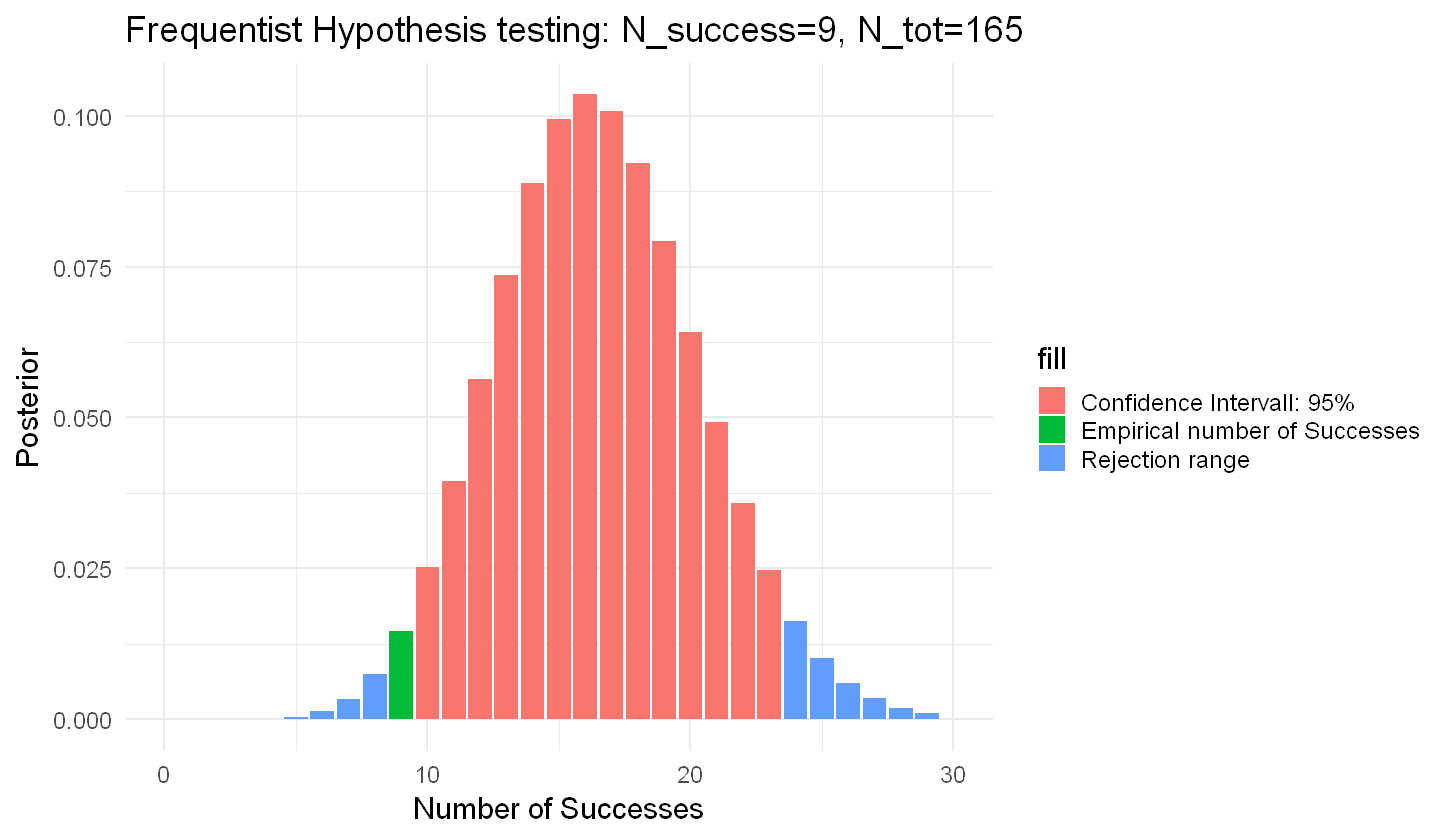

In [37]:
alpha = 0.05
p = seq(0, n, 1)
p.freq = pbinom(p, n, prob=0.1, lower.tail = TRUE)

lower.limit = max(p[p.freq<=alpha/2])
upper.limit = min(p[p.freq>=1-alpha/2])

alpha.star = p.freq[lower.limit] + 1 - p.freq[upper.limit]
cat('The closest we can get to alpha=0.05 is: ', alpha.star, '\n')
cat('The lower and upper limit to the 95% interval are: (', lower.limit, ', ', upper.limit, ')\n')
cat('Since the number of successful events (', y, ') slightly fall whithin this range, we are not sure if we CAN or
    CANNOT reject the null hypotesis. \n')

options(repr.plot.width=12, repr.plot.height=7)
h0.plot <- ggplot()+
    geom_col(aes(x=p, y=dbinom(p, n, 0.1), fill='Confidence Intervall: 95%'))+
    geom_col(aes(x=p[p.freq<=alpha/2], y=dbinom(p[p.freq<=alpha/2], n, 0.1), fill='Rejection range'))+
    geom_col(aes(x=p[p.freq>=1-alpha/2], y=dbinom(p[p.freq>=1-alpha/2], n, 0.1), fill='Rejection range'))+
    geom_col(aes(x=y, y=dbinom(y, n, 0.1), fill='Empirical number of Successes'))+
    xlim(0, 30) +
    labs(x='Number of Successes', y = 'Posterior', title='Frequentist Hypothesis testing: N_success=9, N_tot=165') +
    theme_minimal(base_size = 18)

h0.plot

**Bayesian approach**

In [38]:
cat('Using the old posterior as a prior:\n')
cat('Since p=0.1 slightly falls whithin the 95% CI (',old_low,',',old_up,') we are not sure if we CAN or
    CANNOT reject the null hypotesis.')

cat('\n')
cat('\nUsing the beta(1,10) as a prior:\n')
cat('since p=0.1 slightly falls outside the 95% CI (',beta_low,',',beta_up,') we are not sure if we CAN or
    CANNOT reject the null hypotesis.')

Using the old posterior as a prior:
Since p=0.1 slightly falls whithin the 95% CI ( 0.0436 , 0.1019 ) we are not sure if we CAN or
    CANNOT reject the null hypotesis.

Using the beta(1,10) as a prior:
since p=0.1 slightly falls outside the 95% CI ( 0.0251 , 0.0914 ) we are not sure if we CAN or
    CANNOT reject the null hypotesis.

#### 4)

In [39]:
stan_4 <- stan_model(file = './model/sm_ex6.4.stan')

dataList <- list(y = 11, n = 116)

In [40]:
stanFit <- sampling(object = stan_4, data = dataList, chains = 3, 
                     iter = 10000, warmup = 1000, thin = 1)

In [41]:
print(sprintf('STAN fit'))
cat('\n')
print(stanFit)

[1] "STAN fit"

Inference for Stan model: anon_model.
3 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=27000.

       mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
p      0.09    0.00 0.03   0.05   0.08   0.09   0.11   0.15  9655    1
lp__ -40.24    0.01 0.71 -42.25 -40.42 -39.96 -39.78 -39.73  8851    1

Samples were drawn using NUTS(diag_e) at Mon Jun  3 15:06:20 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [42]:
chain <- rstan::As.mcmc.list(stanFit, pars = c('p'))
summary(chain)


Iterations = 1001:10000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 9000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0940470      0.0259066      0.0001577      0.0002645 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.04975 0.07531 0.09211 0.11045 0.15011 


In [43]:
l.mean.1 <- summary(chain)$statistics[1]

l.med.1 <- summary(chain)$quantiles[3]

print(sprintf('Mean value of p: %.3f', l.mean.1))
print(sprintf('Median value of p: %.3f', l.med.1))
cat('\n')

l.lo.ci.1 <- summary(chain)$quantiles[1]
l.up.ci.1 <- summary(chain)$quantiles[5]

print(sprintf('0.95 CI [%.3f - %.3f]', l.lo.ci.1, l.up.ci.1))

[1] "Mean value of p: 0.094"
[1] "Median value of p: 0.092"

[1] "0.95 CI [0.050 - 0.150]"


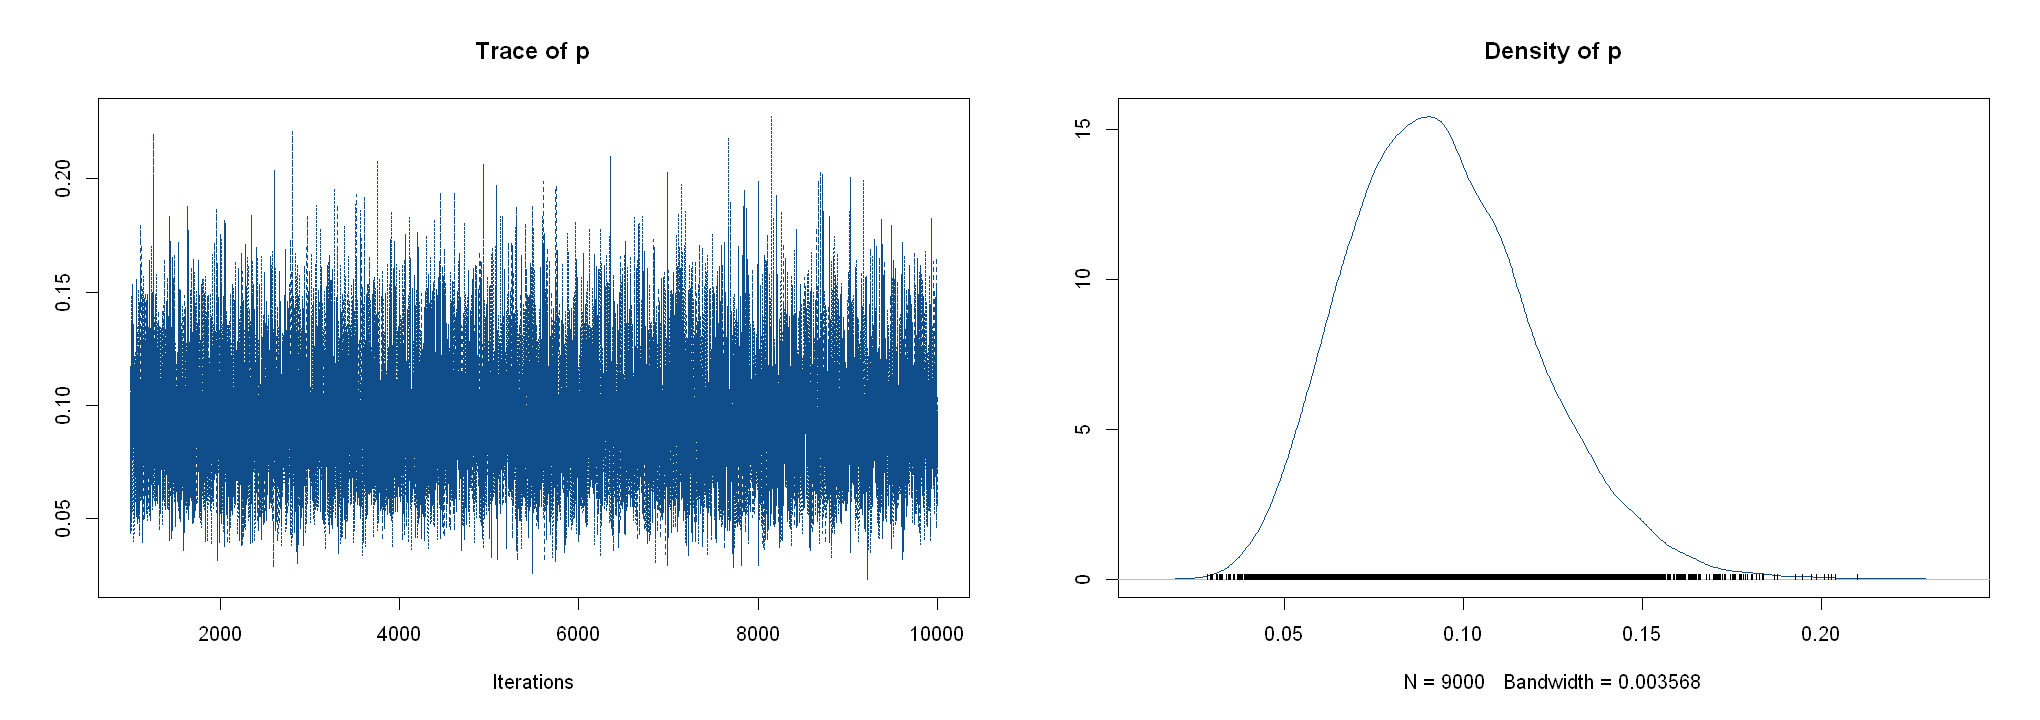

In [44]:
options(repr.plot.width = 17, repr.plot.height = 6)
plot(chain, col='dodgerblue4')